In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession, functions as F
from pyspark.sql import SparkSession 
from pyspark import SparkContext 

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
sc = SparkContext("local", "graphsc")
spark = SparkSession.builder.master('local[*]').appName('sparkgraph').getOrCreate()

In [5]:
#读入车站数据
Station = spark.read.parquet("F:/大三下/并行计算与软件设计/大作业/数据/Station.parquet")
Station.show()
Station.count()

+---+------------+--------+----------+---------+-------+
| id|     Station|Province| Longitude| Latitude|    num|
+---+------------+--------+----------+---------+-------+
|  1|    苍南西站|  浙江省| 120.38268| 27.49879|1230838|
|  2|        温州|  浙江省| 120.69936|27.994267|1196258|
|  3|  义乌火车站|  浙江省|120.042786|29.377123| 973030|
|  4|    东阳东站|  浙江省| 120.25049|29.259472| 929119|
|  5|  无锡客运站|  江苏省| 120.30845|31.592854| 616847|
|  6|    萧山机场|  浙江省| 120.43706|30.234344| 613546|
|  7|    东阳西站|  浙江省| 120.18615|29.298126| 558542|
|  8|  东阳横店站|  浙江省| 120.20354| 29.28787| 505864|
|  9|    南通东站|  江苏省| 120.89203|32.004845| 460216|
| 10|虹桥长途西站|  江苏省|120.845825| 32.00245| 430529|
| 11|    苏州南站|  江苏省|120.638145| 31.27728| 430302|
| 12|        无锡|  江苏省| 120.31191|31.491169| 426063|
| 13|        成都|  四川省| 104.06654| 30.57227| 385386|
| 14|    南京南站|  江苏省| 118.79905|31.968004| 374864|
| 15|        西安|  陕西省| 108.94017|34.341568| 360701|
| 16|    常熟南站|  江苏省| 120.74239|31.628862| 358850|
| 17|都匀客运总站|  贵州省| 107.516

31186

In [6]:
#读入车站关系数据
Station_to_Station = spark.read.parquet("F:/大三下/并行计算与软件设计/大作业/数据/Station_to_Station.parquet")

Station_to_Station = Station_to_Station.withColumnRenamed("Startid",'src')
Station_to_Station = Station_to_Station.withColumnRenamed("Reachid",'dst')

Station_to_Station.show()
Station_to_Station.count()

+-----+-----+---+
|  src|  dst|num|
+-----+-----+---+
|18629|24013|  1|
| 4526| 1868|  1|
| 4754| 1868|  1|
| 2891| 1868|  1|
|15225| 1868|  1|
| 2799|30265|  1|
|19023| 5824|  1|
|11378| 5824|  1|
|  822| 5824|  1|
|23639| 5824|  1|
| 1167| 5824|  1|
| 8666| 5824|  1|
| 1899|29452|  1|
|  730|28737|  1|
|11307| 6297|  1|
| 4977| 6297|  1|
|12132| 6297|  1|
|  947| 6297|  1|
| 6104| 6297|  1|
| 4523| 6297|  1|
+-----+-----+---+
only showing top 20 rows



99047

# pagerank

In [7]:
from graphframes import GraphFrame
sc.setCheckpointDir("./ccpoints")
g = GraphFrame(Station, Station_to_Station)
g = g.filterVertices("num > 1000").filterEdges("num > 50").dropIsolatedVertices()

In [8]:
g.vertices.filter("num > 100000").show(10)
print("权值大于500的边，一共有{}条".format( g.edges.filter("num > 500").count() ))

+---+------------+--------+----------+---------+-------+
| id|     Station|Province| Longitude| Latitude|    num|
+---+------------+--------+----------+---------+-------+
|  1|    苍南西站|  浙江省| 120.38268| 27.49879|1230838|
|  2|        温州|  浙江省| 120.69936|27.994267|1196258|
|  3|  义乌火车站|  浙江省|120.042786|29.377123| 973030|
|  4|    东阳东站|  浙江省| 120.25049|29.259472| 929119|
|  5|  无锡客运站|  江苏省| 120.30845|31.592854| 616847|
|  6|    萧山机场|  浙江省| 120.43706|30.234344| 613546|
|  7|    东阳西站|  浙江省| 120.18615|29.298126| 558542|
|  8|  东阳横店站|  浙江省| 120.20354| 29.28787| 505864|
|  9|    南通东站|  江苏省| 120.89203|32.004845| 460216|
| 10|虹桥长途西站|  江苏省|120.845825| 32.00245| 430529|
+---+------------+--------+----------+---------+-------+
only showing top 10 rows

权值大于500的边，一共有8796条


In [9]:
results = g.pageRank(resetProbability=0.15,maxIter=5)
pagerankvec = results.vertices.select("id", "pagerank").sort(F.col('pagerank').desc())

In [10]:
Station.createOrReplaceTempView('Station')
pagerankvec.createOrReplaceTempView('pagerankvec')
query = """
select Station.*,pagerankvec.pagerank
from pagerankvec,Station
where pagerankvec.id = Station.id
"""
spark.sql(query).show(20)

+---+--------+----------+----------+---------+-------+------------------+
| id| Station|  Province| Longitude| Latitude|    num|          pagerank|
+---+--------+----------+----------+---------+-------+------------------+
| 13|    成都|    四川省| 104.06654| 30.57227| 385386|11.096905915776905|
|591|福州北站|    福建省| 119.31913| 26.11198|  25906| 10.01795778723028|
| 15|    西安|    陕西省| 108.94017|34.341568| 360701| 8.995508631143041|
|202|    郑州|    河南省| 113.62537|34.746597|  75751|  8.04030349181266|
| 69|    长春|    吉林省| 125.32355| 43.81707| 162255| 7.793429599227362|
|199|    济南|    山东省|    117.12|36.651215|  76154| 6.397372340957007|
|397|    东莞|    广东省| 113.75176|23.020536|  38804| 6.248572474434087|
|215|    重庆|    重庆市| 106.55156| 29.56301|  71792| 6.180672320368184|
| 80|广州省站|    广东省| 113.25231| 23.14792| 151141| 6.046302339160144|
|493|    深圳|    广东省| 114.05787|22.543098|  31670| 5.850939619989619|
|339|    武昌|    湖北省|114.299835|30.548456|  46142| 5.316414289722739|
| 84|    兰州|    甘肃省|103

In [15]:
pgshow=spark.sql(query).filter("pagerank>5").select("Station","pagerank","Province",
                                                    "Longitude","Latitude").collect()
pgshow=pd.DataFrame(pgshow)
pgshow.columns = ["车站","PageRank","省份","经度","纬度"]
pgshow["PageRank"]=pd.to_numeric(pgshow["PageRank"]).round(3)
pgshow

,车站,PageRank,省份,经度,纬度
0,成都,11.097,四川省,104.066544,30.572269
1,福州北站,10.018,福建省,119.319130,26.111980
2,西安,8.996,陕西省,108.940170,34.341568
3,郑州,8.040,河南省,113.625366,34.746597
4,长春,7.793,吉林省,125.323547,43.817070
5,济南,6.397,山东省,117.120003,36.651215
6,东莞,6.249,广东省,113.751762,23.020536
7,重庆,6.181,重庆市,106.551559,29.563009
8,广州省站,6.046,广东省,113.252312,23.147921
9,深圳,5.851,广东省,114.057869,22.543098


<BarContainer object of 13 artists>

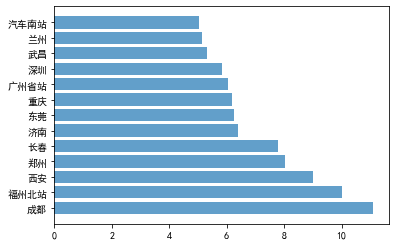

In [16]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.barh(range(1,14),width=pgshow["PageRank"],
        tick_label=pgshow["车站"],alpha=0.7)

## 三角形计数

In [17]:
results = g.triangleCount()
results.select("id","Station","Province","num","count").sort(F.col('count').desc()).show(20)

+---+--------------+--------+------+-----+
| id|       Station|Province|   num|count|
+---+--------------+--------+------+-----+
| 11|      苏州南站|  江苏省|430302| 1035|
| 78|          抚顺|  辽宁省|152071|  581|
| 60|      淮安北站|  江苏省|172464|  567|
|  9|      南通东站|  江苏省|460216|  501|
| 22|      泰州南站|  江苏省|299376|  474|
| 16|      常熟南站|  江苏省|358850|  461|
|154|          庄河|  辽宁省| 96448|  418|
| 61|        瓦房店|  辽宁省|172329|  405|
|410|          青岛|  山东省| 37674|  401|
|  5|    无锡客运站|  江苏省|616847|  378|
| 58|          丹东|  辽宁省|175070|  365|
|521|          淄博|  山东省| 29987|  346|
| 19|  盐城汽车总站|  江苏省|322552|  345|
| 20|      扬州西站|  江苏省|316883|  313|
|171|          凤城|  辽宁省| 87210|  295|
|111|南京汽车客运站|  江苏省|125386|  289|
| 38|          岫岩|  辽宁省|222312|  269|
| 35|    启东汽车站|  江苏省|227132|  267|
| 29|        长沙西|  湖南省|251803|  261|
|692|      东莞总站|  广东省| 21678|  255|
+---+--------------+--------+------+-----+
only showing top 20 rows



## 社区探测：标签传播算法

In [20]:
result = g.labelPropagation(maxIter=5)
label = result.select("id","Station","label")
result.show()

+----+------------------+--------------+----------+---------+-------+-----+
|  id|           Station|      Province| Longitude| Latitude|    num|label|
+----+------------------+--------------+----------+---------+-------+-----+
|3558|        南宁(埌东)|广西壮族自治区| 108.36655|22.817001|   1623| 2310|
|1084|            马家店|        吉林省| 126.23157|44.670086|  11707|   34|
|3586|            宝华镇|        江苏省| 119.04357|32.143944|   1602|   46|
|3702|          桶井梅山|        贵州省| 108.22625|28.050074|   1505|  120|
|4551|            东刘集|        安徽省|  117.6217| 33.24332|   1016|  217|
|3007|          无锡商院|        江苏省| 120.17452|31.565228|   2239|    5|
| 667|          宽甸快客|        辽宁省| 124.07595|40.456444|  22400|   34|
|1053|韶关翁源汽车客运站|        广东省| 113.59752|24.810404|  12174| 1024|
|1894|              蒙阳|        四川省| 103.11895|30.073494|   5028|  101|
|2493|          南昌徐坊|        江西省| 115.98494|28.578297|   3131|  760|
|4399|              盖家|        山东省| 117.64404|37.531948|   1079|   42|
|1325|         

In [21]:
label_ = result.select("Station","Province","Longitude",
                       "Latitude","num","label").filter("label = 34")
label_.createOrReplaceTempView('label_')

query = """
SELECT label_.Province AS Province,COUNT(Province) AS count 
FROM label_
GROUP BY Province
ORDER BY count DESC
"""
l_1=spark.sql(query).collect()

l_1=pd.DataFrame(l_1)
l_1.columns = ["Province","count"]
l_1

,Province,count
0,辽宁省,14
1,吉林省,7
2,黑龙江省,6
3,浙江省,2
4,河北省,2
5,内蒙古自治区,2
6,重庆市,1
7,福建省,1
8,陕西省,1
9,山西省,1


In [22]:
cols=["辽宁省","吉林省","黑龙江省"]
l_2=label_[~label_.Province.isin(cols)].collect()

l_2=pd.DataFrame(l_2)
l_2.columns = ["Station","Province","Longitude",
                       "Latitude","num","label"]
l_2

,Station,Province,Longitude,Latitude,num,label
0,光头山,新疆维吾尔自治区,78.818558,34.790451,5628,34
1,庙岭,山东省,118.214752,35.083229,3240,34
2,枣沟,甘肃省,107.213516,35.995457,4199,34
3,太安,四川省,101.573357,26.556820,3761,34
4,兰旗,河北省,114.839989,41.061932,1001,34
5,于家,浙江省,119.584709,30.072565,1190,34
6,石灰窑,陕西省,109.507378,34.502689,1221,34
7,合隆,重庆市,106.135666,30.309942,10435,34
8,红川,河南省,111.837616,34.989475,1116,34
9,十字街,福建省,118.477623,24.862625,8222,34


In [23]:
#label = result.select("id", "label").filter("label = 5")
#label.show()

label.createOrReplaceTempView('label')
## 查找id对应的车站名
query = """
select Station.*,label.label
from label,Station
where label.id = Station.id
"""
result=spark.sql(query)
result.show()
label.createOrReplaceTempView('result')

+----+------------------+--------------+----------+---------+-------+-----+
|  id|           Station|      Province| Longitude| Latitude|    num|label|
+----+------------------+--------------+----------+---------+-------+-----+
|3558|        南宁(埌东)|广西壮族自治区| 108.36655|22.817001|   1623| 2310|
|1084|            马家店|        吉林省| 126.23157|44.670086|  11707|   34|
|3586|            宝华镇|        江苏省| 119.04357|32.143944|   1602|   46|
|3702|          桶井梅山|        贵州省| 108.22625|28.050074|   1505|  120|
|4551|            东刘集|        安徽省|  117.6217| 33.24332|   1016|  217|
|3007|          无锡商院|        江苏省| 120.17452|31.565228|   2239|    5|
| 667|          宽甸快客|        辽宁省| 124.07595|40.456444|  22400|   34|
|1053|韶关翁源汽车客运站|        广东省| 113.59752|24.810404|  12174| 1024|
|1894|              蒙阳|        四川省| 103.11895|30.073494|   5028|  101|
|2493|          南昌徐坊|        江西省| 115.98494|28.578297|   3131|  760|
|4399|              盖家|        山东省| 117.64404|37.531948|   1079|   42|
|1325|         

In [24]:
label.distinct().count()

4591

In [25]:
query = """
SELECT label AS label,COUNT(label) AS count 
from result
GROUP BY label HAVING COUNT(label)>40
ORDER BY count DESC
"""
result=spark.sql(query)
result.show()
result.count()

+-----+-----+
|label|count|
+-----+-----+
|    5|  346|
|  101|  327|
| 1665|  239|
|   42|  227|
| 1024|  206|
|  217|  194|
|   78|  158|
|  645|  138|
|  523|  132|
|   69|  130|
|  249|  127|
| 1411|   93|
| 1469|   93|
|  893|   75|
|  347|   65|
|  120|   54|
|  408|   54|
|  962|   50|
|  138|   49|
|   34|   44|
+-----+-----+



20